<a href="https://colab.research.google.com/github/Sushmitha-Katti/EVA-4/blob/master/Session9/S9V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-6vpre1j5
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-6vpre1j5
     |████████████████████████████████| 634kB 7.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64514 sha256=dbdff4e8b2262f05cd67d39919bc8c53186f63021d7b05a9a76126ab59b4bb93
  Stored in directory: /tmp/pip-ephem-wheel-cache-7i35f0wu/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=b7f407b61bd30e9aa5ef94025b11b47188c374896c4be156bf966f0e41d53c1d
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
  

In [0]:
from torchvision import transforms
import albumentations as A
import albumentations.pytorch as AP
import random
import numpy as np
class AlbumentationTransforms:
  """
  Helper class to create test and train transforms using Albumentations
  """
  def __init__(self, transforms_list=[]):
    transforms_list.append(AP.ToTensor())

    self.transforms = A.Compose(transforms_list)


  def __call__(self, img):
    img = np.array(img)
    #print(img)
    return self.transforms(image=img)['image']


In [0]:

    
import torch
import torchvision
import torchvision.transforms as transforms
def load():
	
	trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
	testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

	SEED = 1

	# CUDA?
	cuda = torch.cuda.is_available()
	print("CUDA Available?", cuda)

	# For reproducibility
	torch.manual_seed(SEED)

	if cuda:
			torch.cuda.manual_seed(SEED)

	# dataloader arguments - something you'll fetch these from cmdprmt
	dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

	trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
	testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

	classes = ('plane', 'car', 'bird', 'cat',
    	       'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

	return classes, trainloader, testloader

In [0]:
import torch

#Training & Testing Loops
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, criterion, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #loss = F.nll_loss(y_pred, target)
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
	
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss,test_acc

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False), #Rf = 3, j = 1
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(p = 0.1),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False), #Rf = 5, j = 1
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(p = 0.1),

           
            
            )
        self.convblock2 = nn.Sequential(

            #Dilated Network
           nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=1,dilation=2, bias=False), #jout=2, kernel_size = 5, rf = 6+(4)*2 = 14, o/p = 14
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(p = 0.1),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False), #jout=2, kernel_size = 3, rf = 14+(2)*2 = 18, o/p =14
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(p = 0.1),

            
            )

        self.convblock3 = nn.Sequential(
            #DepthWise Seperable Network
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False, groups = 32), # jout = 4, rf = 20+(2)*4 = 28, o/p = 7
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(p = 0.1),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), padding=1, bias=False), #jout = 4, rf = 28+(0)*4 = 28, o/p = 9
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(p = 0.1),

            #DepthWise Seperable Network

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1,groups=64, bias=False),#jout = 4, rf = 28+(2)*4 = 36, o/p = 9
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(p = 0.1),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1, 1), padding=1, bias=False), #jin = jout = 4, rf = 36+(0)*4 = 36, o/p = 11
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(p = 0.1),
            
            )

        self.convblock4 = nn.Sequential(

            #Dialated Network
          nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=1,dilation=2, bias=False), #jout = 8, rf = 40+(4)*8 = 72, o/p = 3
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.15),


            #AVG Pool

            nn.AdaptiveAvgPool2d(1), #op = 1



           nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)#Op_size = 1, 
            

            
            )



        self.pool = nn.MaxPool2d(2, 2)

      


    def forward(self, x):

        x = self.convblock1(x) # i/p= 32 o/p=32 Rf = 6
        x = self.pool(x) # jout = 2, Rf = 6, O/p = 16 
        x = self.convblock2(x) # Rf = 18 jout = 2, o/p =14
        x = self.pool(x) # jout = 4, s = 2, Rf = 18+1*2 = 20, o/p = 7
        x = self.convblock3(x) # jout = 4, Rf = 36, o/p = 11
        x = self.pool(x) # jout = 8, s = 2, Rf = 36+1*4 = 40 o/p = 5
        x = self.convblock4(x)  # o/p = 1
     
        x = x.view(-1, 10)
      
        return x




class BasicBlock(nn.Module):
    expansion = 1
 
    def __init__(self, in_planes, planes, stride=1, dropout=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
 
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        self.dropout = dropout
 
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.dropout(out, p=self.dropout)
        out = self.bn2(self.conv2(out))
        out = F.dropout(out, p=self.dropout)
        out += self.shortcut(x)
        out = F.relu(out)
        out = F.dropout(out, p=self.dropout)
        return out
 
 
class Bottleneck(nn.Module):
    expansion = 4
 
    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
 
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
 
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
 
 
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout=0.0):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.dropout = dropout
 
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
 
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, dropout=self.dropout))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
 
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.dropout(out, p=self.dropout)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
 
 
def ResNet18(dropout=0.0):
    return ResNet(BasicBlock, [2,2,2,2], dropout=0.15)
 
 
 
 


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    fig = plt.figure(figsize=(2,2))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


def show_misclassified_images(model, device, dataset, classes):
  misclassified_images = []
  
  for images, labels in dataset:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(labels)):
              if(len(misclassified_images)<25 and predicted[i]!=labels[i]):
                misclassified_images.append([images[i],predicted[i],labels[i]])
            if(len(misclassified_images)>25):
              break
    
  
  fig = plt.figure(figsize = (10,10))
  for i in range(25):
        sub = fig.add_subplot(5, 5, i+1)
        #imshow(misclassified_images[i][0].cpu())
        img = misclassified_images[i][0].cpu()
        img = img / 2 + 0.5 
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1, 2, 0)),interpolation='none')
        
        sub.set_title("Pred={}, Act={}".format(str(classes[misclassified_images[i][1].data.cpu().numpy()]),str(classes[misclassified_images[i][2].data.cpu().numpy()])))
        
  plt.tight_layout()


            

	# img_list = range(5, 10)

	# # print images
	# imshow(torchvision.utils.make_grid(images[img_list]))
	# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in img_list))

	# images = images.to(device)
	# outputs = model(images)

	# _, predicted = torch.max(outputs, 1)
	# print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
  #                             for j in img_list))


def evaluate_accuracy(model, device, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))


def evaluate_classwise_accuracy(model, device, classes, test_loader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
            	label = labels[i]
            	class_correct[label] += c[i].item()
            	class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision


# functions to show an image
def imshow(img,c = "airp"):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(7,7))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)



def show_random_images(dataset, classes):

	# get some random training images
  print(dataset)
  dataiter = iter(dataset)
  images, labels = dataiter.next()
  for i in range(10):
    index = [j for j in range(len(labels)) if labels[j] == i]
    imshow(torchvision.utils.make_grid(images[index[0:5]],nrow=5,padding=2,scale_each=True),classes[i])

  

	 
	

In [0]:
%matplotlib inline


In [0]:


import numpy as np

import albumentations as A

channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)
train_transform = AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1) # fillvalue is 0 after normalizing as mean is 0
                                       ])





# Test Phase transformations
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])


In [11]:
classes, trainloader, testloader = load()


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CUDA Available? True


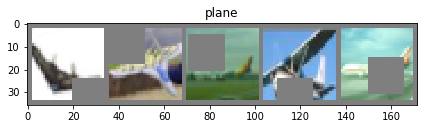

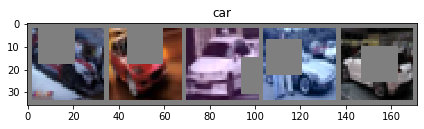

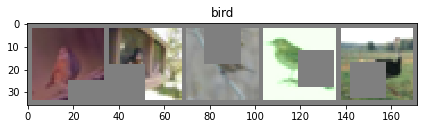

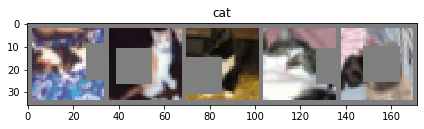

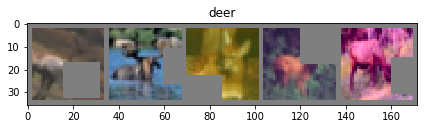

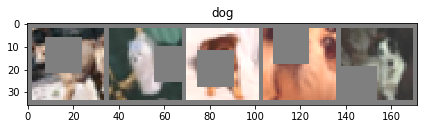

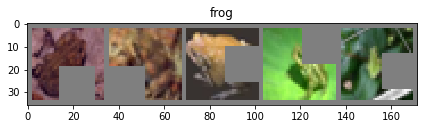

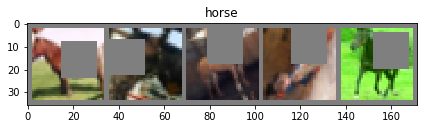

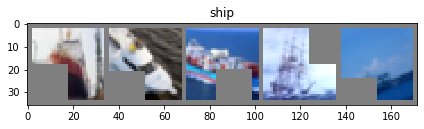

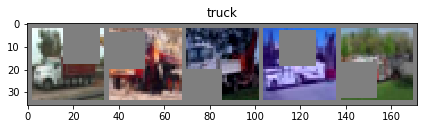

In [12]:
show_random_images(trainloader, classes)

In [13]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [15]:
testLoss = []
testAcc = []
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
    train(model, device, trainloader, optimizer, criterion, epoch)
    scheduler.step()
    test_loss , test_acc = test(model, device, criterion, testloader)
    testLoss.append(test_loss)
    testAcc.append(test_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.1


Loss=1.9524328708648682 Batch_id=390 Accuracy=19.88: 100%|██████████| 391/391 [01:04<00:00,  6.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0141, Accuracy: 3362/10000 (33.62%)

EPOCH: 2 LR: 0.1


Loss=1.9607141017913818 Batch_id=390 Accuracy=32.98: 100%|██████████| 391/391 [01:08<00:00,  6.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0139, Accuracy: 3669/10000 (36.69%)

EPOCH: 3 LR: 0.1


Loss=1.578728437423706 Batch_id=390 Accuracy=38.84: 100%|██████████| 391/391 [01:08<00:00,  6.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Accuracy: 4791/10000 (47.91%)

EPOCH: 4 LR: 0.1


Loss=1.4538867473602295 Batch_id=390 Accuracy=44.78: 100%|██████████| 391/391 [01:08<00:00,  6.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Accuracy: 5151/10000 (51.51%)

EPOCH: 5 LR: 0.1


Loss=1.1412866115570068 Batch_id=390 Accuracy=49.96: 100%|██████████| 391/391 [01:09<00:00,  6.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 5495/10000 (54.95%)

EPOCH: 6 LR: 0.1


Loss=1.368149995803833 Batch_id=390 Accuracy=53.78: 100%|██████████| 391/391 [01:09<00:00,  6.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 6310/10000 (63.10%)

EPOCH: 7 LR: 0.1


Loss=1.2057445049285889 Batch_id=390 Accuracy=56.91: 100%|██████████| 391/391 [01:08<00:00,  6.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 5882/10000 (58.82%)

EPOCH: 8 LR: 0.1


Loss=1.2885655164718628 Batch_id=390 Accuracy=59.57: 100%|██████████| 391/391 [01:08<00:00,  6.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 6795/10000 (67.95%)

EPOCH: 9 LR: 0.1


Loss=1.0629723072052002 Batch_id=390 Accuracy=61.52: 100%|██████████| 391/391 [01:08<00:00,  6.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 6579/10000 (65.79%)

EPOCH: 10 LR: 0.1


Loss=1.1155552864074707 Batch_id=390 Accuracy=62.87: 100%|██████████| 391/391 [01:08<00:00,  6.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 6650/10000 (66.50%)

EPOCH: 11 LR: 0.1


Loss=1.0369269847869873 Batch_id=390 Accuracy=63.78: 100%|██████████| 391/391 [01:08<00:00,  6.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 6855/10000 (68.55%)

EPOCH: 12 LR: 0.1


Loss=0.8684953451156616 Batch_id=390 Accuracy=64.92: 100%|██████████| 391/391 [01:08<00:00,  6.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 7142/10000 (71.42%)

EPOCH: 13 LR: 0.1


Loss=1.0674246549606323 Batch_id=390 Accuracy=65.31: 100%|██████████| 391/391 [01:08<00:00,  6.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 6583/10000 (65.83%)

EPOCH: 14 LR: 0.1


Loss=1.115947961807251 Batch_id=390 Accuracy=66.45: 100%|██████████| 391/391 [01:08<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 7195/10000 (71.95%)

EPOCH: 15 LR: 0.1


Loss=0.8308402895927429 Batch_id=390 Accuracy=66.86: 100%|██████████| 391/391 [01:08<00:00,  6.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 6977/10000 (69.77%)

EPOCH: 16 LR: 0.010000000000000002


Loss=0.6310423612594604 Batch_id=390 Accuracy=73.04: 100%|██████████| 391/391 [01:08<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8143/10000 (81.43%)

EPOCH: 17 LR: 0.010000000000000002


Loss=0.5546020269393921 Batch_id=390 Accuracy=74.97: 100%|██████████| 391/391 [01:08<00:00,  6.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8308/10000 (83.08%)

EPOCH: 18 LR: 0.010000000000000002


Loss=0.6672927141189575 Batch_id=390 Accuracy=75.87: 100%|██████████| 391/391 [01:08<00:00,  6.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8291/10000 (82.91%)

EPOCH: 19 LR: 0.010000000000000002


Loss=0.7448743581771851 Batch_id=390 Accuracy=76.36: 100%|██████████| 391/391 [01:08<00:00,  6.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8372/10000 (83.72%)

EPOCH: 20 LR: 0.010000000000000002


Loss=0.602420449256897 Batch_id=390 Accuracy=77.05: 100%|██████████| 391/391 [01:08<00:00,  6.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8397/10000 (83.97%)

EPOCH: 21 LR: 0.010000000000000002


Loss=0.6341952085494995 Batch_id=390 Accuracy=77.22: 100%|██████████| 391/391 [01:08<00:00,  6.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8413/10000 (84.13%)

EPOCH: 22 LR: 0.010000000000000002


Loss=0.7046079039573669 Batch_id=390 Accuracy=77.30: 100%|██████████| 391/391 [01:08<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8410/10000 (84.10%)

EPOCH: 23 LR: 0.010000000000000002


Loss=0.6442198157310486 Batch_id=390 Accuracy=78.18: 100%|██████████| 391/391 [01:08<00:00,  6.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8420/10000 (84.20%)

EPOCH: 24 LR: 0.010000000000000002


Loss=0.5657283663749695 Batch_id=390 Accuracy=78.39: 100%|██████████| 391/391 [01:08<00:00,  6.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8449/10000 (84.49%)

EPOCH: 25 LR: 0.010000000000000002


Loss=0.7258197665214539 Batch_id=390 Accuracy=78.44: 100%|██████████| 391/391 [01:08<00:00,  6.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8464/10000 (84.64%)

EPOCH: 26 LR: 0.010000000000000002


Loss=0.4983276426792145 Batch_id=390 Accuracy=78.90: 100%|██████████| 391/391 [01:09<00:00,  6.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8525/10000 (85.25%)

EPOCH: 27 LR: 0.010000000000000002


Loss=0.6866806149482727 Batch_id=390 Accuracy=78.87: 100%|██████████| 391/391 [01:08<00:00,  6.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8488/10000 (84.88%)

EPOCH: 28 LR: 0.010000000000000002


Loss=0.4809059500694275 Batch_id=390 Accuracy=79.34: 100%|██████████| 391/391 [01:08<00:00,  6.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8610/10000 (86.10%)

EPOCH: 29 LR: 0.010000000000000002


Loss=0.5272341370582581 Batch_id=390 Accuracy=79.64: 100%|██████████| 391/391 [01:08<00:00,  6.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8561/10000 (85.61%)

EPOCH: 30 LR: 0.010000000000000002


Loss=0.747651219367981 Batch_id=390 Accuracy=79.59: 100%|██████████| 391/391 [01:08<00:00,  6.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8636/10000 (86.36%)

EPOCH: 31 LR: 0.0010000000000000002


Loss=0.5368442535400391 Batch_id=390 Accuracy=81.29: 100%|██████████| 391/391 [01:08<00:00,  6.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8721/10000 (87.21%)

EPOCH: 32 LR: 0.0010000000000000002


Loss=0.5338754057884216 Batch_id=390 Accuracy=82.09: 100%|██████████| 391/391 [01:08<00:00,  6.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8789/10000 (87.89%)

EPOCH: 33 LR: 0.0010000000000000002


Loss=0.4062274396419525 Batch_id=390 Accuracy=82.58: 100%|██████████| 391/391 [01:08<00:00,  6.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8787/10000 (87.87%)

EPOCH: 34 LR: 0.0010000000000000002


Loss=0.5495976209640503 Batch_id=390 Accuracy=82.61: 100%|██████████| 391/391 [01:08<00:00,  6.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8765/10000 (87.65%)

EPOCH: 35 LR: 0.0010000000000000002


Loss=0.5354902148246765 Batch_id=390 Accuracy=82.50: 100%|██████████| 391/391 [01:08<00:00,  6.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8829/10000 (88.29%)

EPOCH: 36 LR: 0.0010000000000000002


Loss=0.5578879117965698 Batch_id=390 Accuracy=82.97: 100%|██████████| 391/391 [01:08<00:00,  6.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8782/10000 (87.82%)

EPOCH: 37 LR: 0.0010000000000000002


Loss=0.4298411011695862 Batch_id=390 Accuracy=82.79: 100%|██████████| 391/391 [01:08<00:00,  6.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8800/10000 (88.00%)

EPOCH: 38 LR: 0.0010000000000000002


Loss=0.6747081875801086 Batch_id=390 Accuracy=82.92: 100%|██████████| 391/391 [01:08<00:00,  6.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8753/10000 (87.53%)

EPOCH: 39 LR: 0.0010000000000000002


Loss=0.4105289876461029 Batch_id=390 Accuracy=82.82: 100%|██████████| 391/391 [01:08<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8797/10000 (87.97%)

EPOCH: 40 LR: 0.0010000000000000002


Loss=0.3700591027736664 Batch_id=390 Accuracy=83.23: 100%|██████████| 391/391 [01:08<00:00,  6.38it/s]



Test set: Average loss: 0.0027, Accuracy: 8826/10000 (88.26%)



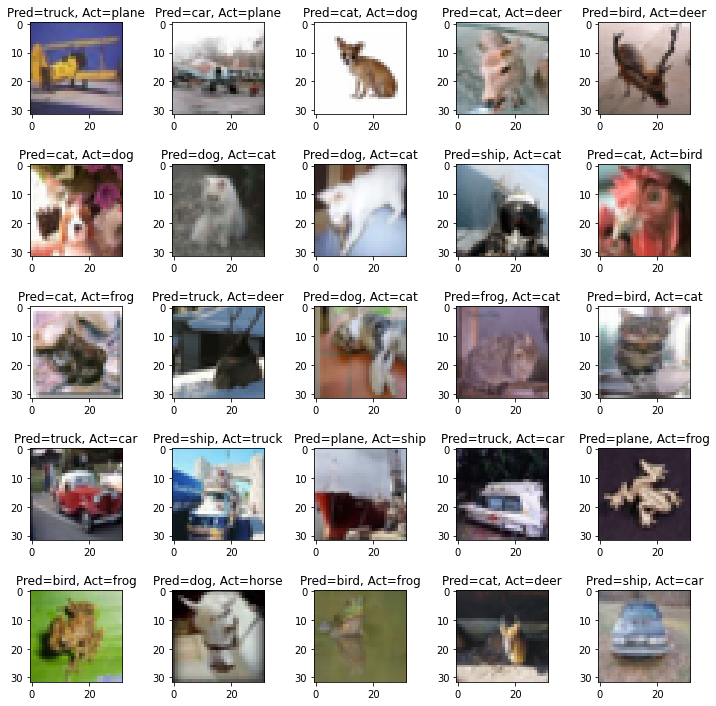

In [16]:
show_misclassified_images(model, device, testloader, classes)

In [17]:
evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 88 %


In [18]:
evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 96 %
Accuracy of   car : 97 %
Accuracy of  bird : 82 %
Accuracy of   cat : 69 %
Accuracy of  deer : 82 %
Accuracy of   dog : 82 %
Accuracy of  frog : 89 %
Accuracy of horse : 96 %
Accuracy of  ship : 90 %
Accuracy of truck : 93 %


Text(0.5, 1.0, 'Test Accuracy')

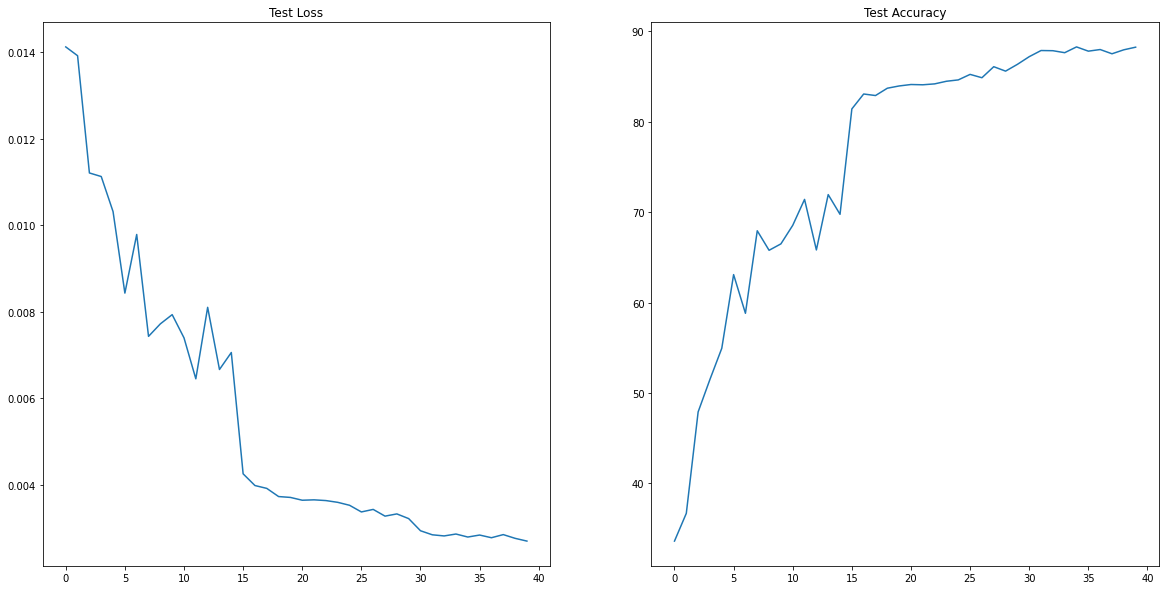

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(testLoss)
axs[0].set_title("Test Loss")


axs[1].plot(testAcc[0])
axs[1].set_title("Test Accuracy")

